# XAS Phase discrepancy between `ripple` and `LAL`

This notebook records the investigation of the apparent phase discrepancy in the `PhenomXAS` waveform between `ripple` and `LALSimulation`.

For the record (for anyone in the future to reproduce this), the versions of `LALSimulation` and `ripple` used are:

For `LALSimulation`, we have:
```python
import lalsimulation; print(lalsimulation.__version__)
> 6.2.0
```
and `ripple` is at this git hash: `20683b318380340e6646dc5764dc8cab13fbbce7`

## The issue:

In a nutshell, the phases that one obtains from `LAL` and `ripple` are off by:
$$
\Psi_{\rm LAL}(f) - \Psi_{\rm ripple}(f) = 3 \phi_c + \pi
$$

**NOTE:** As I will show later, even if this $3 \phi_c$ is accounted for, there is still a frequency-decaying phase difference that remains largely unexplained.

### Common ground:
Here, we call $\Psi$ as the **final final** phase that satisfies:
$$
\tilde{h}_+(f) = A(f) \,\exp(i \Psi)
$$

#### The case in `LALSimulation`

Ultimately, for XAS (in `LAL`), we have:
$$
\Psi(f) = \pi + \Psi_{\rm XAS}(f) + b M f + \phi_{\rm ref}
$$
Notes:
* We have ignored $a = 0$ (it's called `lina` in code)
* This relation is most easily seen from [here](https://git.ligo.org/lscsoft/lalsuite/-/blob/lalsimulation-v6.2.0/lalsimulation/lib/LALSimIMRPhenomX.c?ref_type=tags#L840)
* The leading $\pi$ comes from the $Y_{2,2}$ as noted [here in `LALSimInspiral`](https://git.ligo.org/lscsoft/lalsuite/-/blob/lalsimulation-v6.2.0/lalsimulation/lib/LALSimInspiralGeneratorLegacy.c?ref_type=tags#L2252)

Here, we have ([this chunk](https://git.ligo.org/lscsoft/lalsuite/-/blob/lalsimulation-v6.2.0/lalsimulation/lib/LALSimIMRPhenomX.c?ref_type=tags#L825-L839)):
$$
\Psi_{\rm XAS}(f) = (1 / \eta) \times \texttt{IMRPhenomX\_...\_Phase\_22\_AnsatzInt}(f) 
$$
and (defined [here](https://git.ligo.org/lscsoft/lalsuite/-/blob/lalsimulation-v6.2.0/lalsimulation/lib/LALSimIMRPhenomX.c?ref_type=tags#L748)) 
$$
\phi_{\rm ref} = - (\Psi_{\rm XAS}(f_{\rm ref}) + b M f_{\rm ref}) + 2 \phi_c + \pi/4
$$

Overall, we have:
$$
\begin{align*}
\Psi(f) &= \pi + \Psi_{\rm XAS}(f) + b M f - (\Psi_{\rm XAS}(f_{\rm ref}) + b M f_{\rm ref}) + 2 \phi_c + \pi/4 \\
&= \pi + \Psi_{\rm XAS}(f) - \Psi_{\rm XAS}(f_{\rm ref}) + b M f -  b M f_{\rm ref} + 2 \phi_c + \pi/4
\end{align*}
$$
Note that, however, with only the `PhenomXOnlyReturnPhase` ([here](https://git.ligo.org/lscsoft/lalsuite/-/blob/lalsimulation-v6.2.0/lalsimulation/lib/LALSimIMRPhenomX.c?ref_type=tags#L863-L865)) in `LAL`, it returns $\Psi$ without the leading $\pi$:
$$
\Psi_{\rm LAL}(f) = \Psi(f) - \pi = \Psi_{\rm XAS}(f) - \Psi_{\rm XAS}(f_{\rm ref}) + b M f -  b M f_{\rm ref} + 2 \phi_c + \pi/4
$$

#### The case in `ripple`

In ripple, we have instead ([here](https://github.com/GW-JAX-Team/ripple/blob/20683b318380340e6646dc5764dc8cab13fbbce7/src/ripplegw/waveforms/IMRPhenomXAS.py#L1361)):
$$
\Psi(f) = \Psi_{\rm XAS}(f) + b M f + \phi_{\rm ref} - 2 \pi + 2 \pi f t_c - \phi_c
$$
(this is first output returned when `get_phase` is on, in the modified branch.)

Contribution of $t_c$ in `LAL` is typically done afterwards, so we will ignore it for now, leaving us with:
$$
\Psi(f) = \Psi_{\rm XAS}(f) + b M f + \phi_{\rm ref} - 2 \pi - \phi_c
$$
where $\phi_{\rm ref}$ is computed as ([here](https://github.com/GW-JAX-Team/ripple/blob/20683b318380340e6646dc5764dc8cab13fbbce7/src/ripplegw/waveforms/IMRPhenomXAS.py#L1355)):
$$
\phi_{\rm ref} = - (\Psi_{\rm XAS}(f_{\rm ref}) + b M f_{\rm ref}) + \pi/4 + \pi
$$
So overall, that becomes:
$$
\begin{align*}
\Psi(f) &= \Psi_{\rm XAS}(f) + b M f + (- (\Psi_{\rm XAS}(f_{\rm ref}) + b M f_{\rm ref}) + \pi/4 + \pi) - 2 \pi - \phi_c \\
&= \Psi_{\rm XAS}(f) - \Psi_{\rm XAS}(f_{\rm ref}) + b M f - b M f_{\rm ref} + \pi/4 - \pi - \phi_c 
\end{align*}
$$

#### The verdict

Finally, if one takes their difference, one should get:
$$
\Psi_{\rm LAL}(f) - \Psi_{\rm ripple}(f) = 3 \phi_c + \pi
$$
The rest of this notebook is to show this is indeed the case.

The $\pi$ contribution is relocated perhaps for convenience, but the overall phase shift by $3 \phi_c$ seems weird to be unnoticed before.

In [ ]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt

from ripplegw import ms_to_Mc_eta
from ripplegw.waveforms.IMRPhenomXAS import gen_IMRPhenomXAS_hphc
from ripplegw.waveforms import IMRPhenomXAS as ripple_XAS
from ripplegw.waveforms.IMRPhenomX_utils import \
    PhenomX_phase_coeff_table, PhenomX_amp_coeff_table

from lal import MSUN_SI, MTSUN_SI, PC_SI, CreateDict, TWOPI
import lalsimulation as lalsim
from lalsimulation import \
    SimIMRPhenomXASGenerateFD, \
    SimInspiralChooseFDWaveform, \
    SimInspiralGetApproximantFromString

MPC_SI = PC_SI * 1e6

# Skip the complex to real warnings
import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")

/tmp/ipykernel_958096/3184374212.py:13: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import MSUN_SI, MTSUN_SI, PC_SI, CreateDict, TWOPI


In [2]:
duration = 128.0  # s
sampling_frequency = 8192.0  # Hz
reference_frequency = 30.0  # Hz
f_min = 20.0  # Hz
f_max = sampling_frequency / 2  # Hz
delta_t = 1.0 / sampling_frequency  # s
N_times = int(duration * sampling_frequency)
freqs = np.fft.rfftfreq(N_times, delta_t)
delta_f = np.diff(freqs)[0]

freq_mask = (freqs >= f_min) & (freqs <= f_max)
masked_freqs = freqs[freq_mask]

In [3]:
zero_spin = True
face_on = True

mass_1 = 2.37
mass_2 = 1.37

total_mass = mass_1 + mass_2
mass_ratio = mass_2 / mass_1
chirp_mass, symmetric_mass_ratio = \
    ms_to_Mc_eta(jnp.array([mass_1, mass_2]))
delta = jnp.sqrt(1 - 4 * symmetric_mass_ratio)

if zero_spin:
    chi_1 = 0.0
    chi_2 = 0.0
else:
    chi_1 = 0.12
    chi_2 = 0.14

S_tot_r = (chi_1 + mass_ratio**2 * chi_2) / (1 + mass_ratio**2)
chi_asym = chi_1 - chi_2

Lambda_1 = 0.0
Lambda_2 = 0.0

t_c = 0.0  # Time of coalescence, s
phi_c = 0.7  # Phase of coalescence, rad

luminosity_distance = 100.0  # Mpc
inclination = 0.0 if face_on else np.pi / 3  # rad

### Get phase from `LAL` ($\Psi_{\rm LAL}(f)$)

In [4]:
phase_only_dict = CreateDict()
lalsim.SimInspiralWaveformParamsInsertPhenomXOnlyReturnPhase(phase_only_dict, 1)

_lal_XAS_phase = SimIMRPhenomXASGenerateFD(
    mass_1 * MSUN_SI, mass_2 * MSUN_SI,
    chi_1, chi_2, luminosity_distance * MPC_SI, 
    f_min, f_max, delta_f, phi_c, reference_frequency,
    phase_only_dict
)
lal_XAS_phase = _lal_XAS_phase.data.data

### Get phase from `ripple` ($\Psi_{\rm ripple}(f)$)

In [5]:
intrinsic_theta = jnp.array([
    mass_1, mass_2, chi_1, chi_2
])
extrinsic_theta = jnp.array([
    luminosity_distance, t_c, phi_c
])
phase_coeffs = PhenomX_phase_coeff_table
amplitude_coeffs = PhenomX_amp_coeff_table

ripple_XAS_inners = ripple_XAS._gen_IMRPhenomXAS(
    freqs, intrinsic_theta, extrinsic_theta,
    phase_coeffs, amplitude_coeffs, reference_frequency,
    get_phase=True
)

### Recreate `ripple` phase myself

In [6]:
ripple_Psi_XAS = ripple_XAS.Phase(
    freqs, intrinsic_theta, phase_coeffs
)

## Reconstruct the Ripple `Psi(f)`
ripple_Psi, _, linb, Mfreqs, ripple_phi_ref, _ = ripple_XAS_inners
re_ripple_Psi = ripple_Psi_XAS + linb * Mfreqs + ripple_phi_ref - TWOPI - phi_c # + TWOPI * freqs * t_c
# Ignoring the `t_c`` contribution

### Raw phase comparison

Just to show that all three are "the same" on large scale

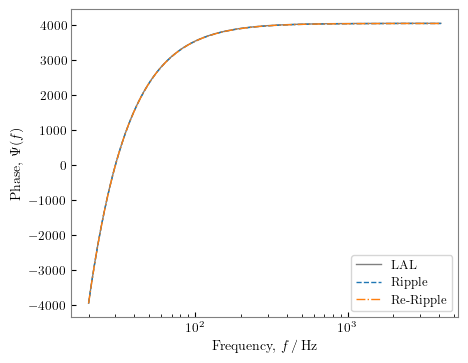

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(masked_freqs, lal_XAS_phase[freq_mask], label='LAL', c='grey')
ax.plot(masked_freqs, ripple_Psi[freq_mask], label='Ripple', ls='--')
ax.plot(masked_freqs, re_ripple_Psi[freq_mask], label='Re-Ripple', ls='-.')
ax.legend()
ax.set_xlabel(r'Frequency, $f\,/\,{\rm Hz}$')
ax.set_ylabel(r'Phase, $\Psi(f)$')
ax.set_xscale('log')

### Phase difference

How much do they differ?

Text(0.5, 1.0, '← Off by a constant shift')

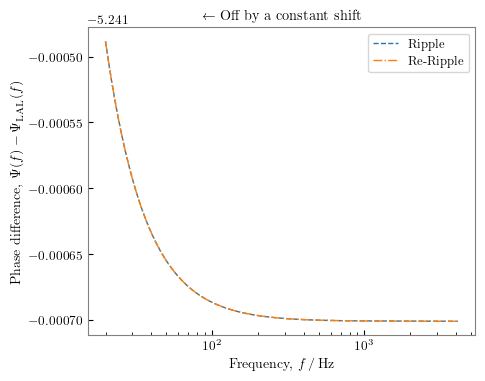

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(masked_freqs, ripple_Psi[freq_mask] - lal_XAS_phase[freq_mask], label='Ripple', ls='--')
ax.plot(masked_freqs, re_ripple_Psi[freq_mask] - lal_XAS_phase[freq_mask], label='Re-Ripple', ls='-.')
ax.legend()
ax.set_xlabel(r'Frequency, $f\,/\,{\rm Hz}$')
ax.set_ylabel(r'Phase difference, $\Psi(f) - \Psi_{\rm LAL}(f)$')
ax.set_xscale('log')
ax.set_title('← Off by a constant shift')

### Phase difference (II)

Is this the difference we expected?

$$
\Delta\Psi = 3 \phi_c - \pi
$$

(1e-09, 2e-07)

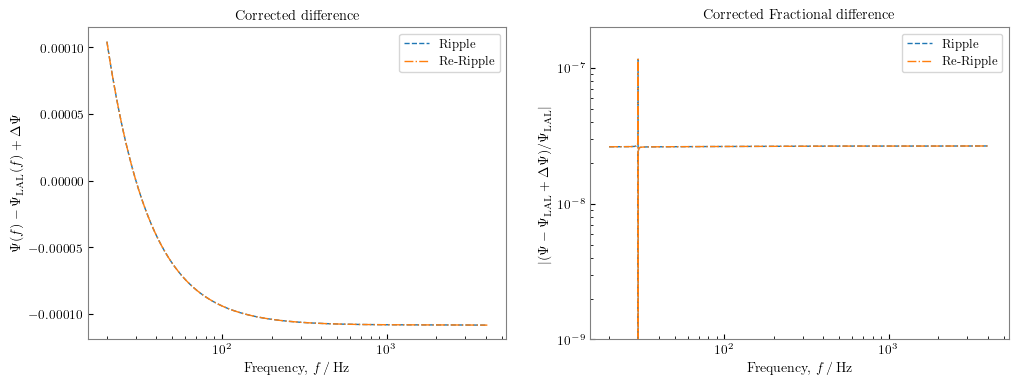

In [9]:
correction_term = 3 * phi_c + np.pi
diff_ripple = ripple_Psi[freq_mask] - lal_XAS_phase[freq_mask] + correction_term
diff_re_ripple = re_ripple_Psi[freq_mask] - lal_XAS_phase[freq_mask] + correction_term

scale = 0.9
fig, axes = plt.subplots(1, 2, figsize=(2 * 6.6 * scale, 4.5 * scale))
ax = axes[0]
ax.plot(masked_freqs, diff_ripple, label='Ripple', ls='--')
ax.plot(masked_freqs, diff_re_ripple, label='Re-Ripple', ls='-.')
ax.legend()
ax.set_xlabel(r'Frequency, $f\,/\,{\rm Hz}$')
ax.set_ylabel(r'$\Psi(f) - \Psi_{\rm LAL}(f) + \Delta\Psi$')
ax.set_title('Corrected difference')
ax.set_xscale('log')

ax = axes[1]
ax.loglog(masked_freqs, np.abs(diff_ripple / lal_XAS_phase[freq_mask]), label='Ripple', ls='--')
ax.loglog(masked_freqs, np.abs(diff_re_ripple / lal_XAS_phase[freq_mask]), label='Re-Ripple', ls='-.')
ax.legend()
ax.set_xlabel(r'Frequency, $f\,/\,{\rm Hz}$')
ax.set_ylabel(r'$\vert (\Psi - \Psi_{\rm LAL} + \Delta\Psi) / \Psi_{\rm LAL}\vert$')
ax.set_title('Corrected Fractional difference')
ax.set_ylim(1e-9, 2e-7)
# ax.set_xscale('log')

At this point, it is clear that the phase difference is real, and the source can be traced back to the code.

However, the frequency-decaying phase difference is still unknown.

My hunch is either:
* there are missing terms in the inpiral phase
* or, we are using different flags somewhere

I think the fact that this difference decays with frequency should be quite a strong hint, as most terms grows with frequency. 
One simply needs to identify the terms that decays with frequency.

### Consequences

Since the apparent $\pi$ shift is simply being accounted for at different stages in `ripple` and `LAL`, it won't be much of an issue when computing hp and hc.

The $3 \phi_c$ however, will remain as an issue, and we shall demonstrate it below:

#### First, we show it for one case

In [10]:
lal_hpc = SimInspiralChooseFDWaveform(
    mass_1 * MSUN_SI, mass_2 * MSUN_SI,
    0.0, 0.0, chi_1,
    0.0, 0.0, chi_2,
    luminosity_distance * MPC_SI,
    inclination, 
    phi_c, 
    0.0, 0.0, 0.0,
    delta_f, f_min, f_max,
    reference_frequency,
    None,
    SimInspiralGetApproximantFromString("IMRPhenomXAS")
)
lal_hp = lal_hpc[0].data.data[freq_mask]
lal_hc = lal_hpc[1].data.data[freq_mask]


ripple_params = jnp.array([
    chirp_mass, symmetric_mass_ratio, 
    chi_1, chi_2, luminosity_distance, 
    t_c, phi_c, inclination
])
ripple_hp, ripple_hc = gen_IMRPhenomXAS_hphc(masked_freqs, ripple_params, reference_frequency)

In [11]:
## Extract phases from hp
lal_hp_amp = np.abs(lal_hp)
lal_exp_psi = lal_hp / lal_hp_amp
lal_hp_phase = np.unwrap(np.angle(lal_exp_psi))

ripple_hp_amp = np.abs(ripple_hp)
ripple_exp_psi = ripple_hp / ripple_hp_amp
ripple_hp_phase = np.unwrap(np.angle(ripple_exp_psi))

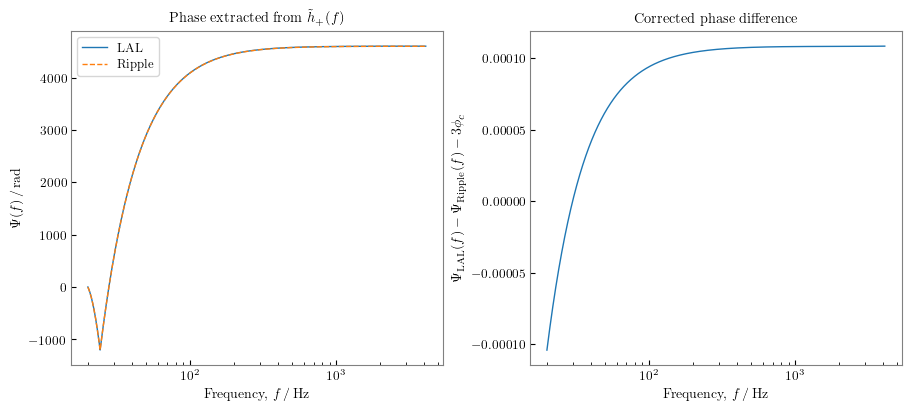

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True)
ax = axes[0]
ax.plot(masked_freqs, lal_hp_phase, label='LAL')
ax.plot(masked_freqs, ripple_hp_phase, label='Ripple', ls='--')
ax.set_xscale('log')
ax.legend()
ax.set_xlabel(r'Frequency, $f\,/\,{\rm Hz}$')
ax.set_ylabel(r'$\Psi(f)\,/\,{\rm rad}$')
ax.set_title(r'Phase extracted from $\tilde h_{+}(f)$')

ax = axes[1]
ax.plot(masked_freqs, lal_hp_phase - ripple_hp_phase - 3 * phi_c)
ax.set_xlabel(r'Frequency, $f\,/\,{\rm Hz}$')
ax.set_ylabel(r'$\Psi_{\rm LAL}(f) - \Psi_{\rm Ripple}(f) - 3 \phi_c$')
ax.set_title('Corrected phase difference')
ax.set_xscale('log')

Note that with the correction term, we recover the same residue as before.

#### Generic trend

Here, we consider a range of $\phi_c$, and show that the phase difference indeed follows the expected $3\,\phi_c$ trend.

In [13]:
phase_diffs = []
nn = 20
phis = np.arange(nn) * (TWOPI / (nn + 1))

for phi_c in phis:
    lal_hpc = SimInspiralChooseFDWaveform(
        mass_1 * MSUN_SI, mass_2 * MSUN_SI,
        0.0, 0.0, chi_1,
        0.0, 0.0, chi_2,
        luminosity_distance * MPC_SI,
        inclination, 
        phi_c, 
        0.0, 0.0, 0.0,
        delta_f, f_min, f_max,
        reference_frequency,
        None,
        SimInspiralGetApproximantFromString("IMRPhenomXAS")
    )
    lal_hp = lal_hpc[0].data.data[freq_mask]
    lal_hc = lal_hpc[1].data.data[freq_mask]

    ripple_params = jnp.array([
        chirp_mass, symmetric_mass_ratio, 
        chi_1, chi_2, luminosity_distance, 
        t_c, phi_c, inclination
    ])
    ripple_hp, ripple_hc = gen_IMRPhenomXAS_hphc(masked_freqs, ripple_params, reference_frequency)
        ## Extract phases from hp
    lal_hp_amp = np.abs(lal_hp)
    lal_exp_psi = lal_hp / lal_hp_amp
    lal_hp_phase = np.unwrap(np.angle(lal_exp_psi))

    ripple_hp_amp = np.abs(ripple_hp)
    ripple_exp_psi = ripple_hp / ripple_hp_amp
    ripple_hp_phase = np.unwrap(np.angle(ripple_exp_psi))

    phase_diffs.append(np.mean(ripple_hp_phase - lal_hp_phase))

Text(0, 0.5, '$\\Delta\\Psi\\,/\\,{\\rm rad}$')

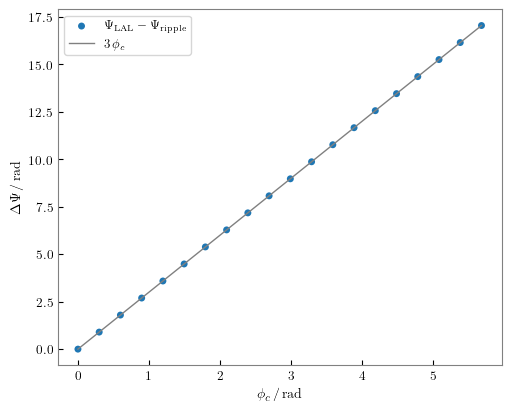

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
ax.scatter(phis, - np.unwrap(phase_diffs), marker='o', label=r'$\Psi_{\rm LAL} - \Psi_{\rm ripple}$')
ax.plot(phis, 3 * phis, c='grey', label=r'$3\,\phi_c$')
ax.legend()
ax.set_xlabel(r'$\phi_c\,/\,{\rm rad}$')
ax.set_ylabel(r'$\Delta\Psi\,/\,{\rm rad}$')

This concludes the trend is indeed true and exists.